## Game2: 4 $\times$ 4 그리드

## imports

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import collections
import IPython

## 예비학습: 시각화 

In [5]:
def render(state): 
    x,y = state
    fig = plt.Figure()
    ax = fig.subplots()
    im = ax.matshow(np.zeros((4,4)), cmap='bwr')
    ax.scatter(x, y, color='red', s=500,alpha=0.3)  # s is the size of the point    
    fig.colorbar(im, ax=ax)
    ax.text(0, 0, 'start', ha='center', va='center')
    ax.text(3, 3, 'end', ha='center', va='center')
    # Adding grid lines to the plot
    ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 4, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    return fig

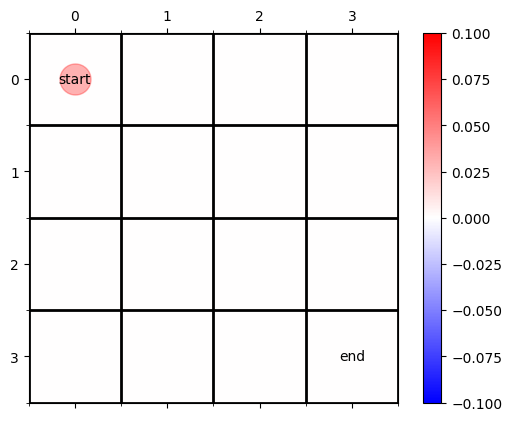

In [6]:
fig = render([0,0])
fig

## Env 클래스 구현

`-` GridWorld: 강화학습에서 많이 사용되는 기본적인 시뮬레이션 환경

1. **State**: 각 격자 셀이 하나의 상태이며, 에이전트는 이러한 상태 중 하나에 있을 수 있음. 
2. **Action**: 에이전트는 상태에서 다른 상태로 이동하기 위해 상, 하, 좌, 우로 이동하는 행동을 할 수 있음. 
3. **Reward**: 에이전트가 특정 행동을 취할 때 환경에서 보상이 주어짐. 
4. **Terminal State**: 일반적으로 하나 또는 그 이상의 종료 상태가 있으며, 에이전트가 이 상태에 도달하면 에피소드가 종료됨. 

`-` 환경과 에이전트 

- env: $(S_t,A_t) \to (S_{t+1}, R_t)$

`-` 수학기호들 

- `state_space`: ${\cal S}=\{1,\dots,16\}=\{(0,0)\dots,(3,3)\}$
- `action_space`: ${\cal A} = \{0,1,2,3\} = \{\text{right}, \text{up}, \text{left}, \text{down}\}$
- `current_state`: $S_t \in {\cal S}$
- `next_state`: $S_{t+1} \in {\cal S}$
- `action`: $A_t \in {\cal A}$
- `reward`: $R_t \in {\cal R}=\{-1,-100,100\}$

In [7]:
class GridWorld:
    def __init__(self):
        self.reset()
        self._action_to_direction = {
            0: np.array([1, 0]), # x+ 
            1: np.array([0, 1]), # y+
            2: np.array([-1, 0]), # x-  
            3: np.array([0, -1]), # y-
        }
        self.state_space = gym.spaces.MultiDiscrete([4, 4])
        self.action_space = gym.spaces.Discrete(4)
    def reset(self):
        self.agent_action = None
        self.agent_state = np.array([0, 0])
        return self.agent_state
    def step(self,action):
        direction = self._action_to_direction[action]
        self.agent_state = self.agent_state + direction
        # 목표지점에 도달 
        if np.array_equal(np.array([3,3]), self.agent_state):
            reward = 100
            terminated = True
        else:
            reward = -1
            terminated = False
        # 4*4밖에 있을 경우 
        if self.agent_state not in self.state_space:
            reward = -100
            terminated = True
            self.agent_state = self.agent_state - 1/2*direction
        return self.agent_state, reward, terminated

In [8]:
env = GridWorld()
env.reset()
states = []
rewards = [] 
terminations = [] 
for t in range(500):
    action = env.action_space.sample()
    state, reward, terminated = env.step(action)
    states.append(state)
    rewards.append(reward)
    terminations.append(terminated)
    if terminated: 
        break 

In [9]:
fig = render([0,0])
ax = fig.gca()

In [10]:
def update(i):
    ax.scatter(states[i][0],states[i][1],color='red',s=500,alpha=0.3)

In [11]:
ani = FuncAnimation(fig,update,frames=len(states))

In [12]:
IPython.display.HTML(ani.to_jshtml())

## Agent 클래스 구현1

`-` 첫번째 시도

In [152]:
# learn 추가
class Agent2_v1:
    def __init__(self,env):
        self.action_space = env.action_space
        self.state_space = env.state_space
        self.n_experiences = 0
        self.n_episode = 0 
        
        ## episode info 
        self.scores = [] 
        self.playtimes = [] 

        ## sars
        self.current_state = None 
        self.action = None
        self.reward = None        
        self.next_state = None 
        
        ## ReplayBuffer
        self.actions = []
        self.rewards = []
        self.current_states = []
        self.next_states = [] 
        self.terminations = []
        
    def act(self):
        self.action = self.action_space.sample()
        
    def save_experience(self): 
        self.actions.append(self.action)
        self.current_states.append(self.current_state)
        self.next_states.append(self.next_state)
        self.rewards.append(self.reward)
        self.terminations.append(self.terminated)
        self.n_experiences = len(self.actions)

In [44]:
env = GridWorld()
agent = Agent2_v1(env)

In [45]:
env.reset()

array([0, 0])

In [46]:
for _ in range(20):
    ### 1. 본질적인 코드
    agent.current_state = env.reset() 
    agent.terminated = False
    agent.score = 0 
    for t in range(50):
        # step1: agent >> env 
        agent.act()
        env.agent_action = agent.action
        # step2: env << agent 
        agent.next_state, agent.reward, agent.terminated = env.step(env.agent_action)
        # step3: 데이터저장 및 학습
        agent.save_experience()
        # step4: 다음 iteration 준비 + 종료조건체크
        agent.current_state = agent.next_state 
        agent.score += agent.reward
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episode = agent.n_episode + 1 
    ## 2. 비본질적 코드
    print(
        f'Episode {agent.n_episode}\t'
        f'Score: {agent.scores[-1]}\t'
        f'Playtime: {agent.playtimes[-1]}'
    )

Episode 1	Score: -104	Playtime: 5
Episode 2	Score: -104	Playtime: 5
Episode 3	Score: -100	Playtime: 1
Episode 4	Score: -100	Playtime: 1
Episode 5	Score: -100	Playtime: 1
Episode 6	Score: -105	Playtime: 6
Episode 7	Score: -100	Playtime: 1
Episode 8	Score: -101	Playtime: 2
Episode 9	Score: -100	Playtime: 1
Episode 10	Score: -101	Playtime: 2
Episode 11	Score: -100	Playtime: 1
Episode 12	Score: -102	Playtime: 3
Episode 13	Score: -103	Playtime: 4
Episode 14	Score: -102	Playtime: 3
Episode 15	Score: -102	Playtime: 3
Episode 16	Score: -105	Playtime: 6
Episode 17	Score: -104	Playtime: 5
Episode 18	Score: -102	Playtime: 3
Episode 19	Score: -100	Playtime: 1
Episode 20	Score: -101	Playtime: 2


`-` 어떻게 학습을 할까? 즉 어떻게 "환경의 이해 $\to$ 행동의 결정" 의 과정을 수행할까? 

1. 어떠한 상태에서, 어떠한 행동을 했을때, 어떠한 보상과 어떠한 다음상태를 받았는지 기록하자.
2. 1을 바탕으로 다음행동을 어떻게 할지 판단하자. 

## 환경의 이해 (1차원적 이해)

`-` 무작위로 10000판을 진행하여 보자. 

In [47]:
env = GridWorld()
agent = Agent2_v1(env)
env.reset()

for _ in range(10000):
    ### 1. 본질적인 코드
    agent.current_state = env.reset() 
    agent.terminated = False
    agent.score = 0 
    for t in range(50):
        # step1: agent >> env 
        agent.act()
        env.agent_action = agent.action
        # step2: env << agent 
        agent.next_state, agent.reward, agent.terminated = env.step(env.agent_action)
        # step3: 데이터저장 및 학습
        agent.save_experience()
        # step4: 다음 iteration 준비 + 종료조건체크
        agent.current_state = agent.next_state 
        agent.score += agent.reward
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episode = agent.n_episode + 1 
    # ## 2. 비본질적 코드
    # print(
    #     f'Episode {agent.n_episode}\t'
    #     f'Score: {agent.scores[-1]}\t'
    #     f'Playtime: {agent.playtimes[-1]}'
    # )

In [48]:
agent.n_experiences

32994

`-` 데이터관찰

In [49]:
agent.current_states[0], agent.actions[0], agent.rewards[0]

(array([0, 0]), 0, -1)

In [50]:
agent.current_states[1], agent.actions[1], agent.rewards[1]

(array([1, 0]), 0, -1)

In [51]:
agent.current_states[2], agent.actions[2], agent.rewards[2]

(array([2, 0]), 3, -100)

In [52]:
agent.current_states[3], agent.actions[3], agent.rewards[3]

(array([0, 0]), 1, -1)

`-` 환경을 이해하기 위한 기록 (1)

In [53]:
q = np.zeros([4,4,4])
count = np.zeros([4,4,4])
for i in range(agent.n_experiences):
    x,y = agent.current_states[i]
    a = agent.actions[i]
    q[x,y,a] = q[x,y,a] + agent.rewards[i]
    count[x,y,a] = count[x,y,a] + 1 

In [54]:
count[count==0] = 0.1
count

array([[[2.972e+03, 3.049e+03, 2.913e+03, 3.062e+03],
        [1.058e+03, 1.027e+03, 1.076e+03, 9.830e+02],
        [3.880e+02, 4.160e+02, 3.480e+02, 3.690e+02],
        [1.420e+02, 1.550e+02, 1.330e+02, 1.430e+02]],

       [[1.058e+03, 9.650e+02, 1.013e+03, 1.006e+03],
        [6.670e+02, 6.990e+02, 7.260e+02, 6.980e+02],
        [3.740e+02, 3.770e+02, 3.510e+02, 3.880e+02],
        [1.630e+02, 1.420e+02, 1.570e+02, 1.580e+02]],

       [[3.720e+02, 4.170e+02, 3.720e+02, 3.970e+02],
        [3.530e+02, 3.720e+02, 3.790e+02, 3.670e+02],
        [2.310e+02, 2.260e+02, 2.450e+02, 2.250e+02],
        [8.800e+01, 1.060e+02, 1.010e+02, 9.400e+01]],

       [[1.050e+02, 1.440e+02, 1.330e+02, 1.370e+02],
        [1.280e+02, 1.430e+02, 1.620e+02, 1.470e+02],
        [9.700e+01, 1.070e+02, 8.700e+01, 8.300e+01],
        [1.000e-01, 1.000e-01, 1.000e-01, 1.000e-01]]])

In [55]:
q = (q/count).round(2)
q

array([[[  -1.,   -1., -100., -100.],
        [  -1.,   -1., -100.,   -1.],
        [  -1.,   -1., -100.,   -1.],
        [  -1., -100., -100.,   -1.]],

       [[  -1.,   -1.,   -1., -100.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1., -100.,   -1.,   -1.]],

       [[  -1.,   -1.,   -1., -100.],
        [  -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.],
        [ 100., -100.,   -1.,   -1.]],

       [[-100.,   -1.,   -1., -100.],
        [-100.,   -1.,   -1.,   -1.],
        [-100.,  100.,   -1.,   -1.],
        [   0.,    0.,    0.,    0.]]])

In [56]:
for i in range(4):
    print(f"action = {i}\n"
          f"action-value function =\n {q[:,:,i]}\n"
          )

action = 0
action-value function =
 [[  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.  100.]
 [-100. -100. -100.    0.]]

action = 1
action-value function =
 [[  -1.   -1.   -1. -100.]
 [  -1.   -1.   -1. -100.]
 [  -1.   -1.   -1. -100.]
 [  -1.   -1.  100.    0.]]

action = 2
action-value function =
 [[-100. -100. -100. -100.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.   -1.]
 [  -1.   -1.   -1.    0.]]

action = 3
action-value function =
 [[-100.   -1.   -1.   -1.]
 [-100.   -1.   -1.   -1.]
 [-100.   -1.   -1.   -1.]
 [-100.   -1.   -1.    0.]]



`-` 환경을 이해하기 위한 기록 (2) -- 이렇게하면 count를 따로 기록할 필요 없음 

In [57]:
q = np.zeros([4,4,4])
for i in range(agent.n_experiences):
    x,y = agent.current_states[i]
    a = agent.actions[i]
    q_estimated = q[x,y,a] # 풀이한 답
    q_observed = agent.rewards[i] # 실제 답
    diff = q_observed - q_estimated # 실제답과 풀이한값의 차이 = 오차피드백값이라고 하자
    q[x,y,a] = q_estimated + 0.05 * diff ## 새로운답 = 원래답 + 오차피드백 * 학습률

In [58]:
for i in range(4):
    print(
        f"action = {i}\n"
        f"action-value function =\n {q[:,:,i].round(1)}\n"
    )

action = 0
action-value function =
 [[ -1.   -1.   -1.   -1. ]
 [ -1.   -1.   -1.   -1. ]
 [ -1.   -1.   -1.   98.9]
 [-99.5 -99.9 -99.3   0. ]]

action = 1
action-value function =
 [[  -1.    -1.    -1.  -100. ]
 [  -1.    -1.    -1.   -99.9]
 [  -1.    -1.    -1.   -99.6]
 [  -1.    -1.    99.6    0. ]]

action = 2
action-value function =
 [[-100.  -100.  -100.   -99.9]
 [  -1.    -1.    -1.    -1. ]
 [  -1.    -1.    -1.    -1. ]
 [  -1.    -1.    -1.     0. ]]

action = 3
action-value function =
 [[-100.    -1.    -1.    -1. ]
 [-100.    -1.    -1.    -1. ]
 [-100.    -1.    -1.    -1. ]
 [ -99.9   -1.    -1.     0. ]]



## 환경의 깊은 이해 (좀 더 고차원적인 이해)

`-` action=1 일때 각 state의 가치 (=기대보상)

In [59]:
q[:,:,1]

array([[ -1.        ,  -1.        ,  -1.        , -99.96475002],
       [ -1.        ,  -1.        ,  -1.        , -99.93133239],
       [ -1.        ,  -0.99999999,  -0.99999076, -99.5647867 ],
       [ -0.99938027,  -0.99934766,  99.58654736,   0.        ]])

`-` 분석1

In [60]:
q[3,2,1] 

99.58654736328279

- 상태 (3,2)에서 행동 1을 하게 되면 100의 보상을 얻으므로 기대보상값은 100근처 -> 합리적임

`-` 분석2 

In [61]:
q[3,1,1] 

-0.9993476576762664

- 상태 (3,1)에서 행동1을 하게 되면 -1의 보상을 얻으므로 기대보상값은 -1 근처 -> 합리적일까? 

`-` 비판: 분석2는 합리적인듯 하지만 data를 분석한뒤는 그다지 합리적이지 못함 

`-` 상황상상 

- 빈 종이를 줌 
- 빈 종이에는 0 또는 1을 쓸 수 있음 (action = 0 or 1)
- 0을 쓸 때와 1을 쓸 때의 보상은 다름
- 그런데 무수히 많은 데이터를 분석한 결과 0을 쓰면 0원을 보상으로 주고, 1을 쓰면 10만원을 보상으로 준다는 것을 "알게 되었음"
- 빈 종이의 가치는 5만원인가? 아니면 10만원인가? --> 10만원 아니야? 

`-` 직관: 생각해보니 `q[3,1,1]`에서는 실제보상(-1)과 잠재적보상(100)을 동시에 고려해야하는게 합리적인듯

In [62]:
q[3,1,1] = (-1) + 0.99 * (100) 

In [63]:
q[:,:,1]

array([[ -1.        ,  -1.        ,  -1.        , -99.96475002],
       [ -1.        ,  -1.        ,  -1.        , -99.93133239],
       [ -1.        ,  -0.99999999,  -0.99999076, -99.5647867 ],
       [ -0.99938027,  98.        ,  99.58654736,   0.        ]])

- 여기에서 0.99 는 "미래에 받을 보상이 현재에 비해 얼마나 중요한지를 결정하는 가중치" 이다. 
- 1에 가까울수록 미래에 받을 보상을 매우 중시한다는 의미 (즉 빈종이 = 십만원 으로 생각한다는 의미)

`-` 수식화: `q[3,1,1] = (-1) + 0.99 * (100)`를 수식화하면 아래와 같다. 

$$q(s,a) = r(s,a) + 0.99\times \max_{a} q(s',a)$$

좀 더 정확하게는 아래와 같이 볼 수 있다. 

$$q(s,a)= \begin{cases} r(s,a) & \text{terminated}  \\ r(s,a)+ 0.99\times \max_{a} q(s',a) & \text{not terminated} \end{cases} $$

In [64]:
q = np.zeros([4,4,4])
for i in range(agent.n_experiences):
    x,y = agent.current_states[i]
    xx,yy = agent.next_states[i]
    a = agent.actions[i]
    q_estimated = q[x,y,a]
    if agent.terminations[i]:
        q_observed = agent.rewards[i] 
    else:
        q_observed = agent.rewards[i] + 0.99*(q[xx,yy,:].max()) # 이걸 관측했다고 치는거임
    diff = q_observed - q_estimated 
    q[x,y,a] = q_estimated + 0.1 * diff

In [65]:
for i in range(4):
    print(
        f"action = {i}\n"
        f"action-value function =\n {q[:,:,i].round(1)}\n"
    )

action = 0
action-value function =
 [[  90.2   92.1   94.1   96. ]
 [  92.1   94.1   96.    98. ]
 [  94.    96.    98.   100. ]
 [-100.  -100.  -100.     0. ]]

action = 1
action-value function =
 [[  90.2   92.1   94.  -100. ]
 [  92.1   94.1   96.  -100. ]
 [  94.1   96.    98.  -100. ]
 [  96.    98.   100.     0. ]]

action = 2
action-value function =
 [[-100.  -100.  -100.  -100. ]
 [  88.3   90.2   92.1   93.9]
 [  90.2   92.1   94.1   95.9]
 [  92.1   94.1   96.     0. ]]

action = 3
action-value function =
 [[-100.    88.3   90.2   92.1]
 [-100.    90.2   92.1   94.1]
 [-100.    92.1   94.1   95.9]
 [-100.    94.    95.9    0. ]]



## 행동전략 

`-` 상태 (0,0)에 있다고 가정해보자. 

In [66]:
q[0,0,:]

array([  90.19349416,   90.19347079, -100.        , -100.        ])

- 행동 0 혹은 1을 하는게 유리함. 

`-` 상태 (2,3)에 있다고 가정해보자. 

In [67]:
q[2,3,:]

array([ 99.99059539, -99.99858842,  95.91339814,  95.94124312])

- 행동 0을 하는게 유리함.

`-` 상태 (3,2)에 있다고 가정해보자. 

In [68]:
q[3,2,:] 

array([-99.99635646,  99.99872958,  95.96573786,  95.92736253])

- 행동 1을 하는게 유리함.

`-` 각 상태에서 최적은 action은 아래와 같다. 

In [69]:
q[0,0,:].argmax()

0

In [70]:
q[2,3,:].argmax()

0

In [71]:
q[3,2,:].argmax()

1

`-` 전략(=정책)을 정리해보자.  

In [72]:
policy = np.array(['?????']*16).reshape(4,4)
policy

array([['?????', '?????', '?????', '?????'],
       ['?????', '?????', '?????', '?????'],
       ['?????', '?????', '?????', '?????'],
       ['?????', '?????', '?????', '?????']], dtype='<U5')

In [73]:
directions = {0: 'down', 1: 'right', 2:'up', 3:'left'}

In [74]:
for i in range(4):
    for j in range(4):
        policy[i,j] = directions[q[i,j,:].argmax()]
policy

array([['down', 'down', 'down', 'down'],
       ['right', 'right', 'down', 'down'],
       ['right', 'right', 'down', 'down'],
       ['right', 'right', 'right', 'down']], dtype='<U5')

## Agent 클래스 구현2

In [169]:
# learn 추가
class Agent2_v2:
    def __init__(self,env):
        self.action_space = env.action_space
        self.state_space = env.state_space
        self.n_experiences = 0
        self.n_episode = 0 
        
        ## episode info 
        self.scores = [] 
        self.playtimes = [] 

        ## sars
        self.current_state = None 
        self.action = None
        self.reward = None        
        self.next_state = None 
        
        ## ReplayBuffer
        self.actions = []
        self.rewards = []
        self.current_states = []
        self.next_states = [] 
        self.terminations = []

        ## q
        self.q = np.zeros([4,4,4])
    def act(self):
        if self.n_experiences < 3000: 
            self.action = self.action_space.sample()
        else: 
            x,y = self.current_state
            self.action = self.q[x,y,:].argmax()
    def save_experience(self): 
        self.actions.append(self.action)
        self.current_states.append(self.current_state)
        self.next_states.append(self.next_state)
        self.rewards.append(self.reward)
        self.terminations.append(self.terminated)
        self.n_experiences = len(self.actions)

    def learn(self): # make q
        x,y = agent.current_state
        xx,yy = agent.next_state
        a = agent.action
        q_estimated = self.q[x,y,a]
        if agent.terminated:
            q_observed = agent.reward
        else:
            q_observed = agent.reward + 0.99*(q[xx,yy,:].max()) 
        # q_observed 와 q_estimated를 점점 비슷하게 만들어주는 역할
        diff = q_observed - q_estimated
        self.q[x,y,a] = q_estimated + 0.1 * diff   

## 구현코드 

In [172]:
env = GridWorld()
agent = Agent2_v2(env)
for _ in range(2000):
    ### 1. 본질적인 코드
    agent.current_state = env.reset() 
    agent.terminated = False
    agent.score = 0 
    for t in range(50):
        # step1: agent >> env 
        agent.act()
        env.agent_action = agent.action
        # step2: env << agent 
        agent.next_state, agent.reward, agent.terminated = env.step(env.agent_action)
        # step3: 데이터저장 및 학습
        agent.save_experience()
        agent.learn()        
        # step4: 다음 iteration 준비 + 종료조건체크
        agent.current_state = agent.next_state 
        agent.score += agent.reward
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episode = agent.n_episode + 1 
    ## 2. 비본질적 코드
    if (agent.n_episode % 100) == 0:
        print(
            f'Episode {agent.n_episode}\t'
            f'Score: {np.mean(agent.scores[-100:]) : .2f}\t'
            f'Playtime: {np.mean(agent.playtimes[-100:]) : .2f}\t'
            f'n_experiences: {agent.n_experiences}'
        )

Episode 100	Score: -96.70	Playtime:  3.70	n_experiences: 370
Episode 200	Score: -95.73	Playtime:  2.73	n_experiences: 643
Episode 300	Score: -100.20	Playtime:  3.20	n_experiences: 963
Episode 400	Score: -98.45	Playtime:  3.45	n_experiences: 1308
Episode 500	Score: -96.14	Playtime:  3.14	n_experiences: 1622
Episode 600	Score: -98.05	Playtime:  3.05	n_experiences: 1927
Episode 700	Score: -98.84	Playtime:  3.84	n_experiences: 2311
Episode 800	Score: -94.49	Playtime:  3.49	n_experiences: 2660
Episode 900	Score: -95.98	Playtime:  2.98	n_experiences: 2958
Episode 1000	Score:  37.16	Playtime:  19.78	n_experiences: 4936
Episode 1100	Score:  77.04	Playtime:  21.94	n_experiences: 7130
Episode 1200	Score:  81.98	Playtime:  19.02	n_experiences: 9032
Episode 1300	Score:  86.84	Playtime:  14.16	n_experiences: 10448
Episode 1400	Score:  89.32	Playtime:  11.68	n_experiences: 11616
Episode 1500	Score:  92.10	Playtime:  8.90	n_experiences: 12506
Episode 1600	Score:  95.00	Playtime:  6.00	n_experiences: 